<a href="https://colab.research.google.com/github/crrivero/FormalMethodsTasting/blob/main/For%20engineers/Mechanical_Engineering_Compatible_Components_Clique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install networkx matplotlib z3-solver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 62.6 MB/s eta 0:00:00


✅ Clique of size 3 found: [S2, B3, H2]


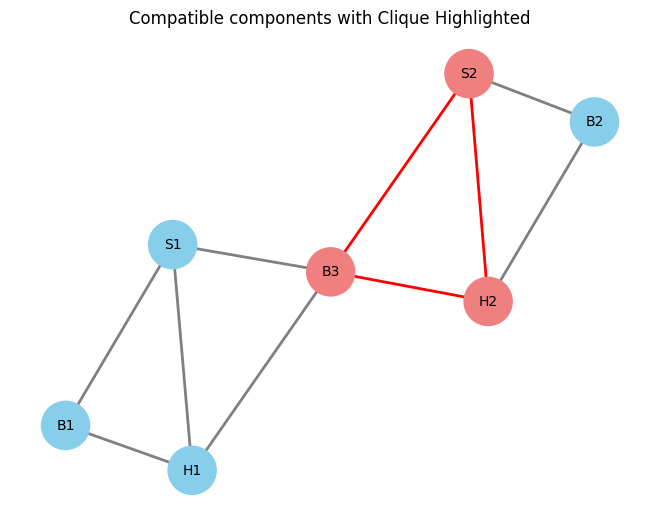

In [10]:
import networkx as nx
from z3 import *
import matplotlib.pyplot as plt

def visualize_compatible_components(edges, clique):
    G = nx.Graph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed=42)

    # Set colors
    node_colors = ["lightcoral" if n in clique else "skyblue" for n in G.nodes()]
    edge_colors = ["red" if u in clique and v in clique else "gray" for u, v in G.edges()]

    # Layout and draw
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors,
        node_size=1200, font_size=10, width=2)
    plt.title("Compatible components with Clique Highlighted")
    plt.show()


# Assemblies consist of components that must be compatible — in terms of
# dimensions, materials, or interfacing standards (e.g., bolt types, surface
# finishes, or coupling styles).

# We aim to design a mechanical joint that requires exactly 3 compatible parts,
# chosen from a catalog of candidate components: 1) A shaft; 2) A bearing; and
# 3) A housing.

# Each part is compatible only with certain other parts (based on constraints
# like size, ISO standard, lubrication compatibility, or mounting style).

k = 3 # Size of the clique to find.

# Step 1: Create Boolean variables for each component
S1, S2, B1, B2, B3, H1, H2 = Bools("S1 S2 B1 B2 B3 H1 H2")

# Where S1 is a small shaft, S2 is a large shaft, B1 is a bearing that fits
# small shaft, B2 is a bearing that fits large shaft, B3 is a universal bearing,
# H1 is a housing that fits B1 and B3, H2 is a housing that fits B2 and B3.

components = [S1, S2, B1, B2, B3, H1, H2]

# Step 2: Define the interactions among components.
# We'll only list the positive interactions
interactions = {
    (S1, B1), (S1, B3), (S1, H1),
    (S2, B2), (S2, B3), (S2, H2),
    (B1, H1), (B3, H1), (B3, H2), (B2, H2)
}

# Step 3: Initialize Z3 solver
solver = Solver()

# Step 4: Add the clique size constraint (exactly k components selected)
solver.add(
    Sum([If(S1, 1, 0), If(S2, 1, 0), If(B1, 1, 0), If(B2, 1, 0),
         If(B3, 1, 0), If(H1, 1, 0), If(H2, 1, 0)]) == k)

# Step 5: Add constraints: if two components are selected, they must interact
# We explicitly write only the required constraints (no loop)
# For every unordered component pair that does NOT interact, add:
#    Not(c1 ∧ c2)  ⇨  ¬(c1 ∧ c2) ⇨  (¬c1 ∨ ¬c2)

# Manually add constraints for non-edges

# Shaft–Bearing
solver.add(Or(Not(S1), Not(B2)))
solver.add(Or(Not(S2), Not(B1)))

# Shaft–Housing
solver.add(Or(Not(S1), Not(H2)))
solver.add(Or(Not(S2), Not(H1)))

# Bearing–Housing
solver.add(Or(Not(B1), Not(H2)))
solver.add(Or(Not(B2), Not(H1)))

# Shaft–Shaft
solver.add(Or(Not(S1), Not(S2)))

# Bearing–Bearing
solver.add(Or(Not(B1), Not(B2)))
solver.add(Or(Not(B1), Not(B3)))
solver.add(Or(Not(B2), Not(B3)))

# Housing–Housing
solver.add(Or(Not(H1), Not(H2)))

if solver.check() == sat:
    model = solver.model()
    clique = [v for v in components if is_true(model[v])]
    print(f"✅ Clique of size {k} found: {clique}")

    visualize_compatible_components(interactions, clique)
else:
    print(f"❌ No clique of size {k} found.")

In [ ]:
""